In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joypy

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge

In [2]:
data_species = pd.read_csv('../Data/features.csv', index_col=0)

data = data_species.copy(deep=True)
data.dropna(inplace=True)

In [3]:
threshold=0.05
print(f'Features correlation with diversity index above threshold: {threshold}')

correlation_with_diversity_index=pd.DataFrame(data.copy(deep=True).corr()['transformed_right_Diversity_index'].sort_values(ascending=False))

correlations_with_diversity = correlation_with_diversity_index[correlation_with_diversity_index.abs() >= threshold].dropna().abs()
correlations_with_diversity.columns = ['Correlation']
correlations_with_diversity.sort_values(by=['Correlation'], ascending=False)

Features correlation with diversity index above threshold: 0.05


,Correlation
transformed_right_Diversity_index,1.000000
Depth,0.212443
Depth_Sbrocco,0.158193
transformed_Coral_cover,0.090912
transformed_right_Wave_exposure,0.086723
transformed_Coral_area_UFRTM_20km,0.060509
Habitat_type_classLV2,0.055272
SG_permits_50km,0.054073
Deepwater,0.052969
NPP,0.050979


Depth and Depth_Sbrocco are two measures of depth, so we will keep the one with higher correlation.

Selecting features with high absolute correlations

In [4]:
features = ['Depth','transformed_Coral_cover','transformed_right_Wave_exposure','Deepwater','NPP']

Splitting the dataset into training and testing

In [5]:
# Prepare the data for the model
# Separate features and target
X = data[features]

y = data['transformed_right_Diversity_index']


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

To plot the results, we create a dataframe

In [6]:
results = pd.DataFrame(y_test)
results = results.reset_index().drop(columns=['index'])
results.columns = ['Real_value']

We will also store the Errors and R2 scores for each models into a dataframe

In [7]:
errors_dict = {}

In [8]:
### Helper function for the model calibration

In [9]:
def calibration(model, model_name, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    
    predict_model = model.predict(x_test)

    mae = mean_absolute_error(y_test, predict_model) #The lower the better
    mse = mean_squared_error(y_test, predict_model) #The lower the better
    r2 = r2_score(y_test, predict_model) #Closer to 1 better
    
    result_dict = {'MAE':mae, 'MSE':mse, 'R2':r2}
    
    temp = pd.DataFrame(predict_model)
    temp.columns = [model_name]

    return temp, result_dict


### Linear regression model

In [10]:
model = linear_model.LinearRegression()
y, d = calibration(model, 'Linear_regression',X_train, y_train, X_test, y_test)
results = pd.concat([results, y], axis=1)
errors_dict['Linear_regression'] =  d

### RandomForestRegressor model

In [11]:
# Train a Random Forest model
model = RandomForestRegressor(random_state=42)
y, d = calibration(model, 'RandomForestRegressor',X_train, y_train, X_test, y_test)
results = pd.concat([results, y], axis=1)
errors_dict['RandomForestRegressor'] =  d

## Support Vector Regression model

### SVR Poly

### Poly

In [12]:

model = SVR(kernel = 'linear')

y, d = calibration(model, 'SVR_linear',X_train, y_train, X_test, y_test)
results = pd.concat([results, y], axis=1)
errors_dict['SVR_linear'] =  d

### SVR rbf

In [13]:
model = SVR(kernel = 'rbf')

y, d = calibration(model, 'SVR_rbf',X_train, y_train, X_test, y_test)
results = pd.concat([results, y], axis=1)
errors_dict['SVR_rbf'] =  d


### Ridge

In [14]:

model = Ridge(alpha=1.0)

y, d = calibration(model, 'Ridge',X_train, y_train, X_test, y_test)
results = pd.concat([results, y], axis=1)
errors_dict['Ridge'] =  d

### Lasso

In [15]:

model = Lasso(alpha=0.1)

y, d = calibration(model, 'Lasso',X_train, y_train, X_test, y_test)
results = pd.concat([results, y], axis=1)
errors_dict['Lasso'] =  d

### GradientBoostingRegressor

In [16]:

model = GradientBoostingRegressor(n_estimators=100)

y, d = calibration(model, 'GradientBoostingRegressor',X_train, y_train, X_test, y_test)
results = pd.concat([results, y], axis=1)
errors_dict['GradientBoostingRegressor'] =  d

### KNeighborsRegressor

In [17]:


model = KNeighborsRegressor(n_neighbors=3)

y, d = calibration(model, 'KNN',X_train, y_train, X_test, y_test)
results = pd.concat([results, y], axis=1)
errors_dict['KNN'] =  d

### AdaBoostRegressor

In [18]:

model = AdaBoostRegressor(n_estimators=50)

y, d = calibration(model, 'AdaBoost',X_train, y_train, X_test, y_test)
results = pd.concat([results, y], axis=1)
errors_dict['AdaBoost'] =  d

In [19]:
melted_results = results.melt(id_vars='Real_value', value_vars=results.columns[1:])

We plot the y test vs the y real values for each model to see if one outperforms (we expect to see a straight line x=y if the model is performing very good)

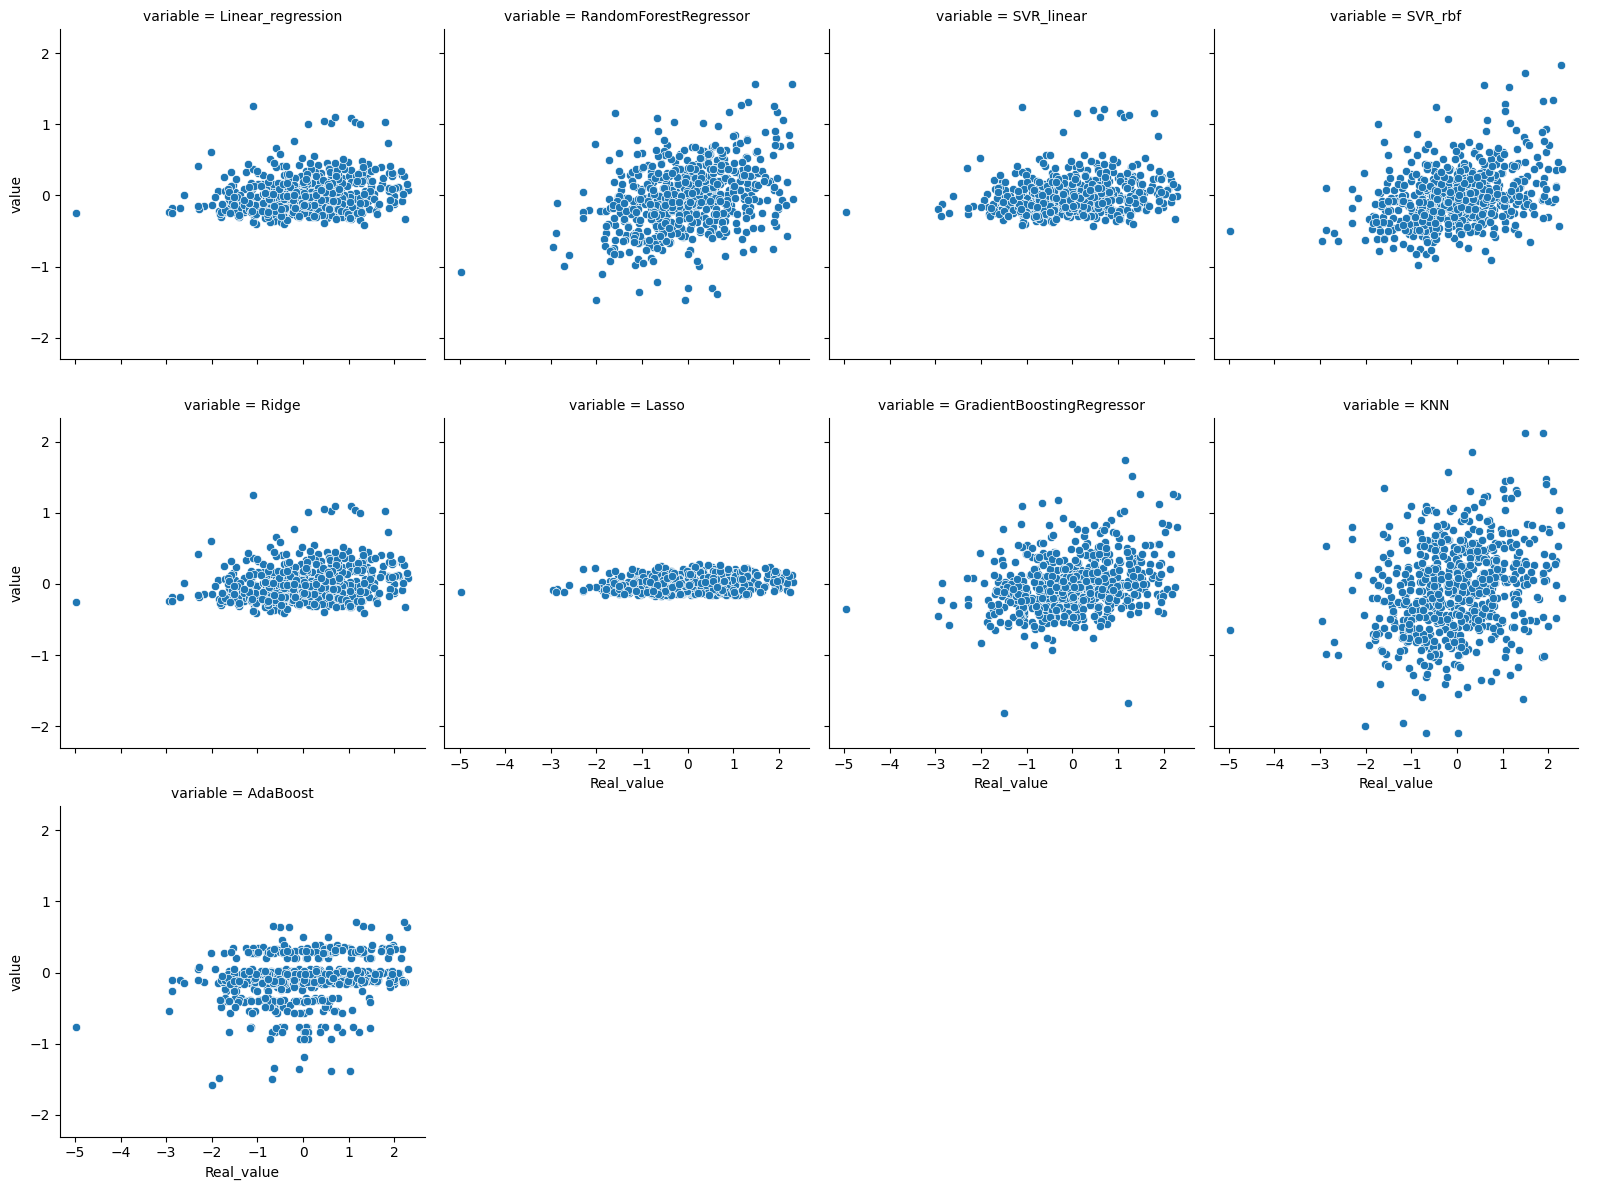

In [20]:
# Create the FacetGrid
g = sns.FacetGrid(melted_results, col='variable', col_wrap=4, height=4)

# Map the scatter plot onto the grid
g.map(sns.scatterplot, 'Real_value', 'value')

# Adjust layout
g.add_legend()
plt.show()

In [23]:
pd.DataFrame(errors_dict)

,Linear_regression,RandomForestRegressor,SVR_linear,SVR_rbf,Ridge,Lasso,GradientBoostingRegressor,KNN,AdaBoost
MAE,0.766108,0.724642,0.766494,0.734653,0.766109,0.776881,0.744639,0.821541,0.783525
MSE,0.944555,0.876627,0.946553,0.881720,0.944549,0.961372,0.916125,1.084058,0.967734
R2,0.054069,0.122096,0.052067,0.116995,0.054075,0.037227,0.082540,-0.085638,0.030856


**Conclusion**: We do not believe the data at hand will allow us to run a regression task. We more believe we will be able to get good results with a classification engine